# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd

#used for feature analysis
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [3]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = len(student_data.columns)
n_passed = len(student_data[student_data.passed == "yes"])
n_failed = n_students - n_passed
grad_rate = n_passed * 1.0 / n_students
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 31
Graduation rate of the class: 0.67%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [4]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
print X_all.head()  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...    

### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

Investigating potential continuous inputs
**************************************************
Investigating feature age


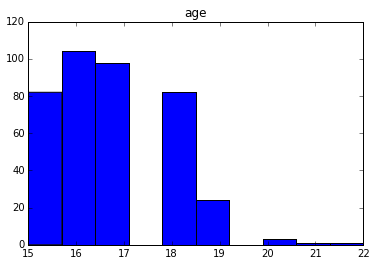

Mean 16.70
Median 17.00
Std Dev 1.27
Unique values 8
Age looks like it should be ok as there are not many different values
**************************************************
Investigating feature absences


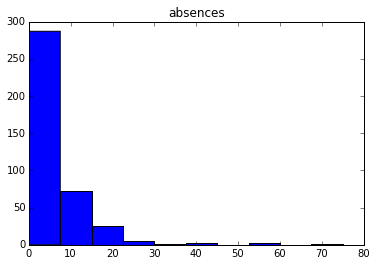

Mean 5.71
Median 4.00
Std Dev 7.99
Unique values 34
Absences should be put into bins as there are many different values


In [5]:
def hist_feature(feature_name, **kwargs):
    print '*' * 50
    print "Investigating feature %s" % feature_name
    plt.hist(X_all[feature_name], **kwargs)
    plt.title(feature_name)
    plt.show()
    
    print "Mean %.2f" % np.mean(X_all[feature_name])
    print "Median %.2f" % np.median(X_all[feature_name])
    print "Std Dev %.2f" % np.std(X_all[feature_name])
    print "Unique values %d" % len(np.unique(X_all[feature_name]))
    

print "Investigating potential continuous inputs"
hist_feature('age')
print "Age looks like it should be ok as there are not many different values"


hist_feature('absences')
print "Absences should be put into bins as there are many different values"

In [6]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty
        
    # Check each column
    for col, col_data in X.iteritems():        
        #if we are dealing with absences then bin descretize it into bands of 10
        #if col_data.name == 'absences':
        #    col_data = col_data.apply(lambda x: (int) (x * 1.0 /25))
        
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'      
            
        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

#unique_value_per_feature = [(col, len(X_all[col].unique())) for col in X_all.columns]
#for a in unique_value_per_feature:
#    print "%s %s" % a

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [7]:
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
# Create a list with the index numbers randomised
random_index = np.random.permutation(num_all)
random_train_index = random_index[:num_train]
random_test_index = random_index[num_train:]

X_train = X_all.loc[random_train_index]
y_train = y_all[random_train_index]
X_test = X_all.loc[random_test_index]
y_test = y_all[random_test_index]
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [8]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training KNeighborsClassifier...
Done!
Training time (secs): 0.001


In [9]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {}".format(train_f1_score)

Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.010
F1 score for training set: 0.869757174393


In [10]:
# Predict on test data
print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003
F1 score for test set: 0.753623188406


In [11]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
for max_items in [100, 200, 300]:
    train_predict(clf, X_train[:max_items], y_train[:max_items], X_test, y_test)

------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.828025477707
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.794520547945
------------------------------------------
Training set size: 200
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.862745098039
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.777777777778
------------------------------------------
Training set size: 300
Training KNeighborsClassifier...
Done!
Training time (secs): 0.001
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.007
F1 score for training

In [14]:
# TODO: Train and predict using two other models
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

for max_items in [100, 200, 300]:
    train_predict(clf, X_train[:max_items], y_train[:max_items], X_test, y_test)

------------------------------------------
Training set size: 100
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.001
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.72131147541
------------------------------------------
Training set size: 200
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.002
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for training set: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.753846153846
------------------------------------------
Training set size: 300
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.003
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set: 1

In [15]:
# TODO: Train and predict using two other models
from sklearn.svm import SVC
clf = SVC()

for max_items in [100, 200, 300]:
    train_predict(clf, X_train[:max_items], y_train[:max_items], X_test, y_test)

------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.002
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.867924528302
Predicting labels using SVC...
Done!
Prediction time (secs): 0.001
F1 score for test set: 0.797385620915
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.005
Predicting labels using SVC...
Done!
Prediction time (secs): 0.003
F1 score for training set: 0.871473354232
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.794520547945
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.008
Predicting labels using SVC...
Done!
Prediction time (secs): 0.006
F1 score for training set: 0.866242038217
Predicting labels using SVC...
Done!
Prediction time (secs): 0.002
F1 score for test set: 0.772413793103


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [98]:
# TODO: Fine-tune your model and report the best F1 score